# Task 5: Image Compression with Matrix Factorization

In this notebook, we'll use Matrix Factorization (MF) to compress a small image patch. Unlike inpainting, here we have all the pixel data for the patch. The goal is to find a **low-rank approximation** that captures the patch's visual information using significantly fewer numbers.

### The Math: The Essence of Compression

An $N \times N$ image patch, $M$, can be represented by $N^2$ numbers. If $M$ has a low-rank structure, we can approximate it as the product of two smaller matrices, $W$ (size $N \times r$) and $H$ (size $r \times N$):
$$
M_{N \times N} \approx W_{N \times r} H_{r \times N}
$$
To store this approximation, we only need to store the elements of $W$ and $H$, which totals $(N \times r) + (r \times N) = 2Nr$ numbers.

For our $50 \times 50$ patch, the original storage is $50^2 = 2500$ values. If we use a `rank` of $r=5$, the compressed storage is just $2 \times 50 \times 5 = 500$ values—an **80% reduction** in storage space. We will explore how the reconstruction quality (measured by PSNR) changes as we vary the rank `r`.

In [1]:
import torch
import numpy as np
import sys
import os
import matplotlib.pyplot as plt

# Add the src directory to the Python path
sys.path.append(os.path.abspath(os.path.join('..', 'src')))

# Import our custom modules
from data_loader import load_image, get_image_patch
from training import factorize_patch_gd
from utils import calculate_image_metrics
from visualize import plot_compression_results

# Setup device
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

/Users/devanshlodha/Documents/github/signal-synth-ml/signal-synth-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: mps


## 1. Data Preparation

We'll load an image and extract a random 50x50 patch to serve as our compression target.

In [2]:
# --- 1. Load Image and Extract Patch ---
IMG_PATH = '../data/images/krustykrab.png'
original_img = load_image(IMG_PATH, device)[:3, :, :] 

PATCH_SIZE = 50
image_patch, x_start, y_start = get_image_patch(original_img, PATCH_SIZE)

patch_coords = (y_start, y_start + PATCH_SIZE, x_start, x_start + PATCH_SIZE)
print(f"Extracted 50x50 patch starting at (y:{y_start}, x:{x_start})")

Extracted 50x50 patch starting at (y:173, x:533)


## 2. Compression via Matrix Factorization

We will now loop through a range of `rank` values. For each rank, we'll factorize the patch, reconstruct it, splice it back into the original image for context, and calculate the fidelity metrics.

--- Running Compression for rank = 5 ---


Rank 5 -> RMSE: 0.0074, PSNR: 42.62 dB

--- Running Compression for rank = 10 ---


Rank 10 -> RMSE: 0.0066, PSNR: 43.56 dB

--- Running Compression for rank = 25 ---


Rank 25 -> RMSE: 0.0053, PSNR: 45.54 dB

--- Running Compression for rank = 50 ---


Rank 50 -> RMSE: 0.0034, PSNR: 49.28 dB



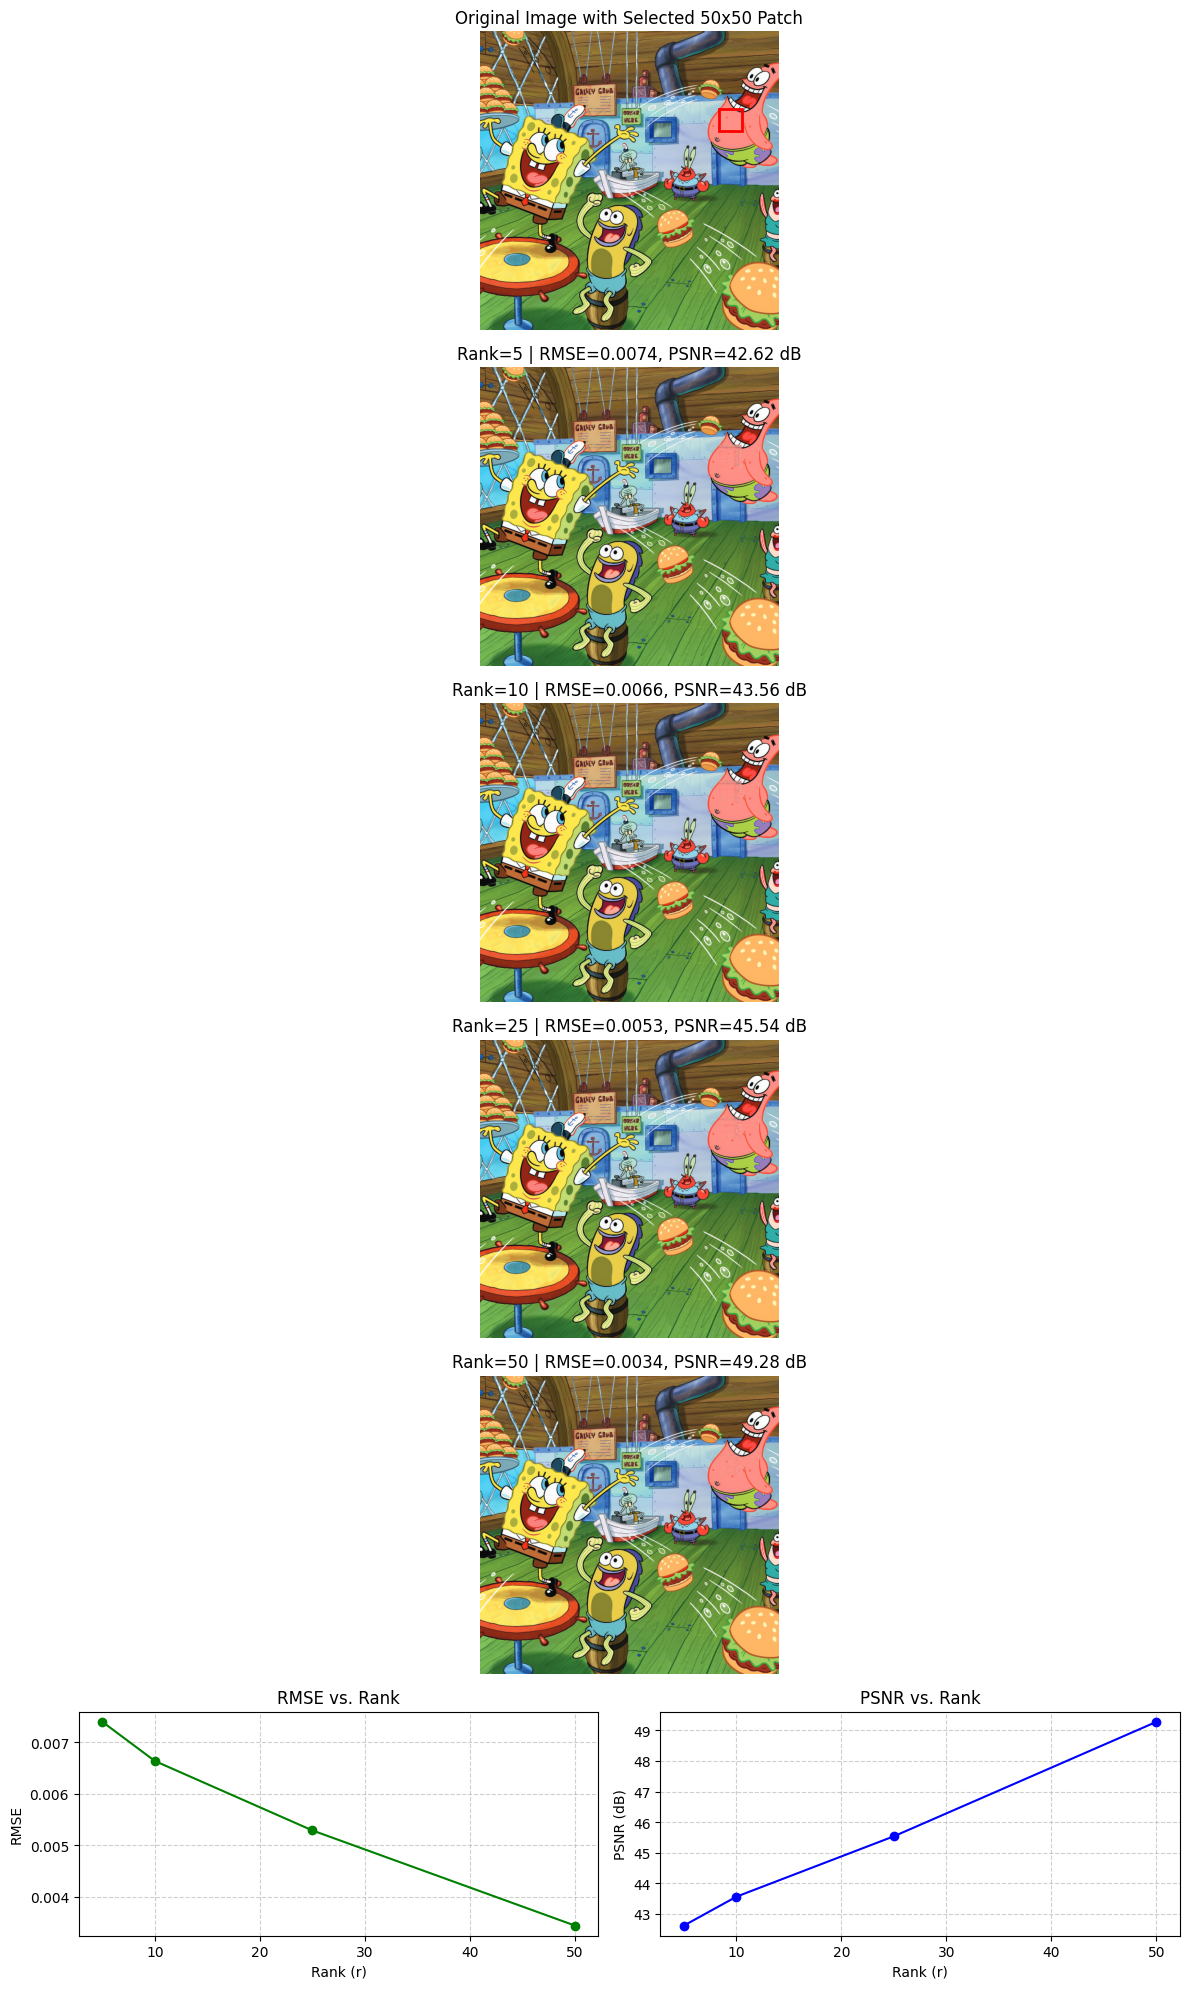

In [3]:
# --- 1. Define Hyperparameters ---
rank_values = [5, 10, 25, 50]
EPOCHS = 4000
LR = 1e-3
results = []

# --- 2. Run Compression for each Rank ---
for rank in rank_values:
    print(f"--- Running Compression for rank = {rank} ---")
    
    # Factorize each color channel of the patch
    W_r, H_r = factorize_patch_gd(image_patch[0], rank, EPOCHS, LR, device)
    W_g, H_g = factorize_patch_gd(image_patch[1], rank, EPOCHS, LR, device)
    W_b, H_b = factorize_patch_gd(image_patch[2], rank, EPOCHS, LR, device)
    
    with torch.no_grad():
        reconstructed_patch = torch.stack([W_r @ H_r, W_g @ H_g, W_b @ H_b], dim=0)

    # Create a copy of the original image to splice our reconstructed patch into
    reconstructed_full_img = original_img.clone()
    reconstructed_full_img[:, y_start:y_start+PATCH_SIZE, x_start:x_start+PATCH_SIZE] = reconstructed_patch
    
    # --- 3. Calculate metrics against the full original image ---
    rmse, psnr = calculate_image_metrics(original_img, reconstructed_full_img)
    results.append({
        'rank': rank, 
        'rmse': rmse, 
        'psnr': psnr, 
        'image': reconstructed_full_img
    })
    print(f"Rank {rank} -> RMSE: {rmse:.4f}, PSNR: {psnr:.2f} dB\n")

# --- 4. Visualize All Results ---
plot_compression_results(original_img, results, patch_coords)